<a href="https://colab.research.google.com/github/scr47One/Haskell/blob/master/transferencia_estilo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kornia
!git clone https://www.github.com/EugenHotaj/pytorch-generative pytorch_generative_all 
!mv pytorch_generative_all/pytorch_generative pytorch_generative

     |████████████████████████████████| 309 kB 5.3 MB/s 
Cloning into 'pytorch_generative_all'...
remote: Enumerating objects: 1227, done.
remote: Counting objects: 100% (472/472), done.
remote: Compressing objects: 100% (362/362), done.
remote: Total 1227 (delta 334), reused 218 (delta 110), pack-reused 755
Receiving objects: 100% (1227/1227), 37.08 MiB | 17.52 MiB/s, done.
Resolving deltas: 100% (837/837), done.


In [3]:
import copy

import kornia
from pytorch_generative import colab_utils
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms

print(colab_utils.get_device())

ModuleNotFoundError: ignored

In [8]:
colab_utils.upload_files()
!ls /tmp

dap_multiplexer.1ff195feab60.root.log.INFO.20210911-051848.68
dap_multiplexer.INFO
debugger_bpw2pe2cd
initgoogle_syslog_dir.0


/content/pytorch_generative/colab_utils.py:74: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  size = size if isinstance(size, collections.Sequence) else (size, size)


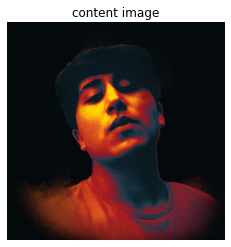

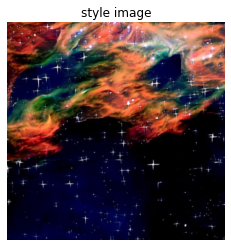

In [3]:
imsize = 512 if torch.cuda.is_available() else 128  # Use a small size on CPU.

content_img = colab_utils.load_image("/tmp/perfil rojosazul.png", size=imsize)
style_imgs = [
  colab_utils.load_image("/tmp/ESPACIO4.jpg", size=imsize),
  # More style images can be loaded here.
]

colab_utils.imshow(content_img, title="content image")
for style_img in style_imgs:
  colab_utils.imshow(style_img, title="style image")

In [4]:
class ImageNetNormalize(nn.Module):
  """Module which normalizes inputs using the ImageNet mean and stddev."""

  def __init__(self):
    super().__init__()
    mean = torch.tensor((0.485, 0.456, 0.406)).view(1, 3, 1, 1)
    std = torch.tensor((0.229, 0.224, 0.225)).view(1, 3, 1, 1)
    self.register_buffer('_mean', mean)
    self.register_buffer('_std', std)

  def forward(self, input):
    return (input - self._mean.to(input.device)) / self._std.to(input.device)

class ContentLoss(nn.Module):
  """The content loss module.
  
  Computes the L1 loss between the target and the input.
  """

  def __init__(self, target):
    """Initializes a new ContentLoss instance.
    
    Args:
      target: Take the L1 loss with respect to this target.
    """
    super().__init__()
    # Detach target since we do not want to use it for gradient computation.
    self._target = target.detach()
    self.loss = None

  def forward(self, input):
    self.loss = F.l1_loss(input, self._target)
    return input


class StyleLoss(nn.Module):
  """The style loss module.
  
  Computes the L1 loss between the gram matricies of the target feature and the
  input.
  """

  def __init__(self, target_feature):
    """Initializes a new StyleLoss instance.
    
    Args:
      target_feature: Take the L1 loss with respect to this target feature.
    """
    super().__init__()
    # Detach target since we do not want to use it for gradient computation.
    self._target = self._gram_matrix(target_feature.detach()).detach()
    self.loss = None

  def _gram_matrix(self, input):
    """Returns the normalized Gram matrix of the input."""
    n, c, w, h = input.size()
    features = input.view(n * c, w * h)
    G = torch.mm(features, features.t())
    return G.div(n * c * w * h)

  def forward(self, input):
    G = self._gram_matrix(input)
    self.loss = F.l1_loss(G, self._target)
    return input


def get_nst_model_and_losses(
    model,  content_img,  style_imgs, content_layers, style_layers):
  """Creates the Neural Style Transfer model and losses. 

  We assume the model was pretrained on ImageNet and normalize all inputs using
  the ImageNet mean and stddev.

  Args:
    model: The model to use for Neural Style Transfer. ContentLoss and StyleLoss
      modules will be inserted after each layer in content_layers and 
      style_layers respectively.
    content_img: The content image to use when creating the ContentLosses.
    style_imgs: The list of style images to use when creating the StyleLosses.
    content_layers: The name of the layers after which a ContentLoss module will
      be inserted.
    style_layers: The name of the layers after which a StyleLoss module will be
      inserted.
  Returns: A three item tuple of the NST model with ContentLoss and StyleLoss 
    modules inserted, the ContentLosses modules, and the StyleLosses modules.
  """
  nst_model = nn.Sequential(ImageNetNormalize())
  content_losses, style_losses, last_layer = [], [], 0
  for i, (name, layer) in enumerate(copy.deepcopy(model).named_children()):
    nst_model.add_module(name, layer)
    if name in content_layers:
      content_loss = ContentLoss(nst_model(content_img))
      nst_model.add_module(f'{name}_ContentLoss', content_loss)
      content_losses.append(content_loss)
      last_layer = i
    if name in style_layers:
      for j, style_img in enumerate(style_imgs):
        style_loss = StyleLoss(nst_model(style_img))
        nst_model.add_module(f'{name}_StyleLoss_{j}', style_loss)
        style_losses.append(style_loss)
        last_layer = i + j
  # Sanity check that we have the desired number of style and content layers.
  assert len(content_losses) == len(content_layers), 'Not all content layers found.'
  assert len(style_losses) / len(style_imgs) == len(style_layers), 'Not all style layers found.'
  # Remove the layers after the last StyleLoss and ContentLoss since they will
  # not be used for style transfer. To get the correct last_layer index, we 
  # take into account the ImageNetNormalization layer at the front and the
  # ContentLoss and StyleLoss layers.
  last_layer += 1 + len(content_losses) + len(style_losses)
  nst_model = nst_model[:last_layer+1]
  return nst_model, content_losses, style_losses 

In [5]:
# TODO(eugenhotaj): This function also replaces the model's ReLU and Pooling
# layers. Therefore, the name of this method is misleading. We should either
# rename the method to something more appropriate, or move the replacement logic
# to get_style_model_and_losses.
def rename_vgg_layers(model):
  """Renames VGG model layers to match those in the paper."""
  block, number = 1, 1
  renamed = nn.Sequential()
  for layer in model.children():
    if isinstance(layer, nn.Conv2d):
      name = f'conv{block}_{number}'
    elif isinstance(layer, nn.ReLU):
      name = f'relu{block}_{number}'
      # The inplace ReLU version doesn't play nicely with NST.
      layer = nn.ReLU(inplace=False)
      number += 1
    elif isinstance(layer, nn.MaxPool2d):
      name = f'pool_{block}'
      # Average pooling was found to generate images of higher quality than
      # max pooling by Gatys et al.
      layer = nn.AvgPool2d(layer.kernel_size, layer.stride)
      block += 1
      number = 1
    else:
      raise RuntimeError(f'Unrecognized layer "{layer.__class__.__name__}""') 
    renamed.add_module(name, layer)
  return renamed

In [6]:
model = models.vgg19(pretrained=True).features.eval()
model = rename_vgg_layers(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [1]:
def run_style_transfer(
    model, 
    content_img, 
    style_imgs, 
    content_layers,
    style_layers,
    input_img=None, 
    num_steps=512, 
    content_weight=1., 
    style_weight=1e9,
    log_steps=50):
  """Runs Neural Style Transfer.
  
  Args:
    model: The Neural Style Transfer model to use.
    content_image: The image whose content to match during the optimization. 
    style_imgs: The list of images whose style to match during the optimization.
    content_layers: The names of the layers whose output will be used to compute
      the content losses.
    style_layers: The names of the layers whose output will be used to compute
      the style losses.
    input_img: The image which will be optimized to match the content and style
      of the content_img and style_imgs respectively. If None, defaults to 
      random Gaussian noise.
    num_steps: The number of steps to run the optimization for.
    content_weight: A weight to multiply the content loss by. 
    style_weight: A weight to multiply the style loss by. 
    log_steps: The number of consecutive training steps to run before logging.
  Returns:
    The optimized input_img.
  """
  device = colab_utils.get_device()
  model = model.to(device)
  content_img = content_img.unsqueeze(0).to(device)
  style_imgs = [style_img.unsqueeze(0).to(device) for style_img in style_imgs]
  n, c, h, w = content_img.data.size()
  if h != w:
    print(f"WARNING: Non-square images may require re-tuning hyperparameters.")
  if input_img is None:
    input_img = torch.randn((n, c, h, w), device=device)
    input_img = input_img * .01  # Scale the noise variance down.
    
  model, content_losses, style_losses = get_nst_model_and_losses(
      model, content_img, style_imgs, content_layers, style_layers)
  model = model.to(device) 
  optimizer = optim.Adam([input_img.requires_grad_()], lr=.05)
  # NOTE(eugenhotaj): Making the generated image robust to minor transformations
  # was shown in https://distill.pub/2017/feature-visualization to produce more
  # visually appealing results. We observe the same thing but note that our
  # transformations are a lot more mild as aggresive transformations produce 
  # rotation and scaling artifacts in the generated image.
  transform = nn.Sequential(
    kornia.augmentation.RandomResizedCrop(
        size=(h, w), scale=(.97, 1.), ratio=(.97, 1.03)),
    kornia.augmentation.RandomRotation(degrees=1.))
  for step in range(num_steps):
    optimizer.zero_grad()
    input_img.data.clamp_(0, 1)
    if h == w:
      model(transform(input_img))
    else:
      model(input_img)
    content_loss, style_loss = 0, 0
    for cl in content_losses:
      content_loss += content_weight * cl.loss
    for sl in style_losses:
      style_loss += style_weight * sl.loss
    loss = content_loss + style_loss 
    loss.backward()
    optimizer.step()
    
    if (step > 0 and step % log_steps == 0) or (step + 1) == num_steps:
      print(f'[{step}]:content_loss={content_loss.item()},'
            f' style_loss={style_loss.item():4f}')
      colab_utils.imshow(input_img.data.clamp_(0, 1), figsize=(10, 10))
  return input_img

In [2]:
# NOTE(eugenhotaj): It's unclear from Gatys et al. whether to use the outputs of
# the conv layer or the (ReLU) activations. We use the latter here as ad-hoc
# experiments did not show a difference in quality, although the loss seems to
# be a lot higher when using the conv layer outputs.
vgg_default_content_layers = ['relu4_2']
vgg_default_style_layers = [
  'relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

# Uncomment one of the lines below to use as the input_img to optimize.
input_img = None
# input_img = content_img.clone()
# input_img = style_imgs[0].clone()

output = run_style_transfer(
    model=model, 
    content_img=content_img, 
    style_imgs=style_imgs,
    # Note(eugenhotaj): Gatys et al. use conv4_2 as the content layer. However,
    # we found that relu3_2 produces more visually appealing results.
    content_layers=['relu3_2'],
    style_layers=vgg_default_style_layers,
    num_steps=3500,
    content_weight=1.,
    style_weight=1500.,
    log_steps=250)

NameError: ignored